In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style()
%matplotlib inline
!python --version

Python 3.5.2 :: Anaconda 4.2.0 (64-bit)


In [2]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import desc
import pyspark.sql.functions as F
import numpy as np

spark = SparkSession.builder.appName("Sample Data Testing...").getOrCreate()

In [3]:
def load_year(year):
    location = "data/311_Service_Requests_from_" + str(year) + ".csv"
    return spark.read.csv(location, header=True, inferSchema=True, dateFormat="MM/dd/yyyy hh:mm:ss a")

In [4]:
# Add to this function as needed
def clean_and_load(df):
    return df.selectExpr("cast(unix_timestamp(`Created Date`, 'MM/dd/yyyy hh:mm:ss a') AS timestamp) AS created_date",
                         "cast(unix_timestamp(`Closed Date`, 'MM/dd/yyyy hh:mm:ss a') AS timestamp) AS closed_date",
                         "`Agency` AS agency",
                         "`Complaint Type` AS complaint_type",
                         "`Descriptor` AS descriptor",
                         "cast(`Incident Zip` AS int) AS zipcode",
                         "`City` AS city",
                         "`Latitude` AS latitude",
                         "`Longitude` AS longitude")

In [5]:
df = load_year(2012)

In [6]:
!ls -hl data/

total 13G
-r--r--r-- 1 sam sam 1.2G Aug 12 21:17 311_Service_Requests_from_2012.csv
-r--r--r-- 1 sam sam 1.2G Aug 12 21:17 311_Service_Requests_from_2013.csv
-r--r--r-- 1 sam sam 1.4G Aug 12 21:17 311_Service_Requests_from_2014.csv
-r--r--r-- 1 sam sam 1.5G Aug 12 21:17 311_Service_Requests_from_2015.csv
-r--r--r-- 1 sam sam 1.3G Oct 18 20:38 311_Service_Requests_from_2016.csv
-rw-rw-r-- 1 sam sam  20K Oct 18 22:17 derby.log
drwxrwxr-x 1 sam sam  142 Oct 18 22:18 metastore_db
-rw-rw-r-- 1 sam sam 6.2G Oct 18 03:56 nyc311.csv


In [7]:
df.printSchema()

root
 |-- Unique Key: integer (nullable = true)
 |-- Created Date: string (nullable = true)
 |-- Closed Date: string (nullable = true)
 |-- Agency: string (nullable = true)
 |-- Agency Name: string (nullable = true)
 |-- Complaint Type: string (nullable = true)
 |-- Descriptor: string (nullable = true)
 |-- Location Type: string (nullable = true)
 |-- Incident Zip: string (nullable = true)
 |-- Incident Address: string (nullable = true)
 |-- Street Name: string (nullable = true)
 |-- Cross Street 1: string (nullable = true)
 |-- Cross Street 2: string (nullable = true)
 |-- Intersection Street 1: string (nullable = true)
 |-- Intersection Street 2: string (nullable = true)
 |-- Address Type: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Landmark: string (nullable = true)
 |-- Facility Type: string (nullable = true)
 |-- Status: string (nullable = true)
 |-- Due Date: string (nullable = true)
 |-- Resolution Description: string (nullable = true)
 |-- Resolution Actio

In [8]:
zips = clean_and_load(df)
zips.cache()

DataFrame[created_date: timestamp, closed_date: timestamp, agency: string, complaint_type: string, descriptor: string, zipcode: int, city: string, latitude: double, longitude: double]

In [9]:
zips.count()

1780427

# Zipcodes
The dataset includes a zip code column in addition to longitude/latitude ones. Let's see which zip codes are commonly seen in this dataset.

In [10]:
zips.groupBy('zipcode').count().sort(desc("count")).show()

+-------+------+
|zipcode| count|
+-------+------+
|   null|130636|
|  11226| 32448|
|  10467| 28853|
|  10458| 25088|
|  11207| 24469|
|  10452| 21998|
|  11221| 21991|
|  10453| 20895|
|  10468| 20761|
|  11208| 20243|
|  10457| 20053|
|  11213| 19848|
|  10456| 19817|
|  11212| 19378|
|  11216| 19147|
|  10031| 19028|
|  11225| 18764|
|  11233| 18703|
|  11203| 18671|
|  11385| 18667|
+-------+------+
only showing top 20 rows



In [11]:
# Anything showing up here can potentially be manually classified for zip code
zips.filter(zips.zipcode.isNull() & zips.latitude.isNotNull() & zips.longitude.isNotNull()).count()

692

# Cities Column
Inspection below seems to indicate that the dataset includes some cities which are not New York, Brooklyn, etc... We should make sure to filter these out. It also appears that so far none of these have latitude or longitude coordinates.

The city column is also blank in ~130000 of these. We should see if these have zipcodes/long/lat that are within the limits of NYC.

In [12]:
# Not sure why some of these cities are in here....
cities = zips.selectExpr('city').toPandas()
city_counts = zips.groupBy('city').count().toPandas()

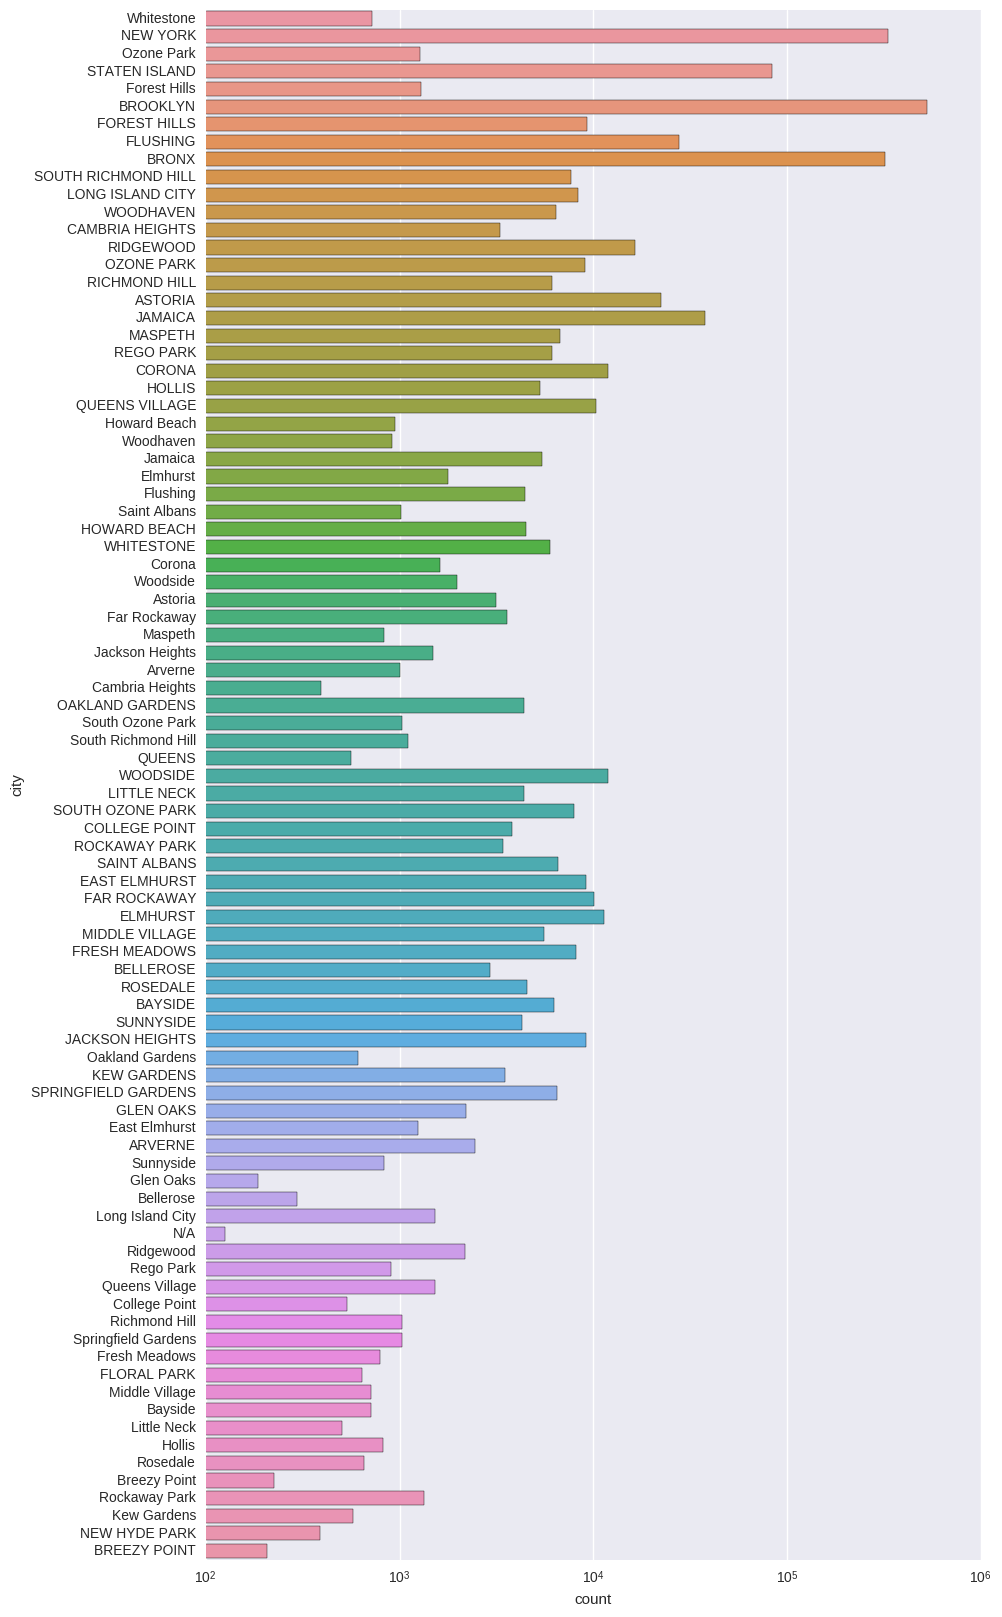

In [13]:
popular_cities = city_counts[city_counts['count'] > 100]['city']
fig,ax = plt.subplots(1, 1, figsize=(10,20))
sns.countplot(y='city', data=cities[cities['city'].isin(popular_cities)], ax=ax)
ax.set_xscale('log')

In [14]:
zips.filter(zips.city.isNull()).count()

129593

In [15]:
print("Orlando:")
zips.filter(zips.city == "ORLANDO").select("city", "latitude", "longitude", "zipcode").show()
print("Atlanta:")
zips.filter(zips.city == "ATLANTA").select("city", "latitude", "longitude", "zipcode").show()

Orlando:
+-------+--------+---------+-------+
|   city|latitude|longitude|zipcode|
+-------+--------+---------+-------+
|ORLANDO|    null|     null|   null|
|ORLANDO|    null|     null|  32857|
|ORLANDO|    null|     null|   null|
|ORLANDO|    null|     null|  32805|
+-------+--------+---------+-------+

Atlanta:
+-------+--------+---------+-------+
|   city|latitude|longitude|zipcode|
+-------+--------+---------+-------+
|ATLANTA|    null|     null|  30328|
|ATLANTA|    null|     null|  30360|
|ATLANTA|    null|     null|   null|
|ATLANTA|    null|     null|  31146|
+-------+--------+---------+-------+



# Complaint Types

Let's see what sort of complaints tend to be found and in which zip codes they are most common (and/or which complaint is the most common in each zip code).

In [16]:
zips.groupBy('complaint_type', 'descriptor').count().sort(desc('count')).show(50, False)

+------------------------+-------------------------------------------------------+------+
|complaint_type          |descriptor                                             |count |
+------------------------+-------------------------------------------------------+------+
|HEATING                 |HEAT                                                   |181541|
|Noise - Residential     |Loud Music/Party                                       |86536 |
|Street Light Condition  |Street Light Out                                       |68821 |
|NONCONST                |VERMIN                                                 |43805 |
|Blocked Driveway        |No Access                                              |38732 |
|PAINT - PLASTER         |CEILING                                                |37472 |
|Street Condition        |Pothole                                                |37107 |
|PAINT - PLASTER         |WALLS                                                  |36979 |
|PLUMBING 

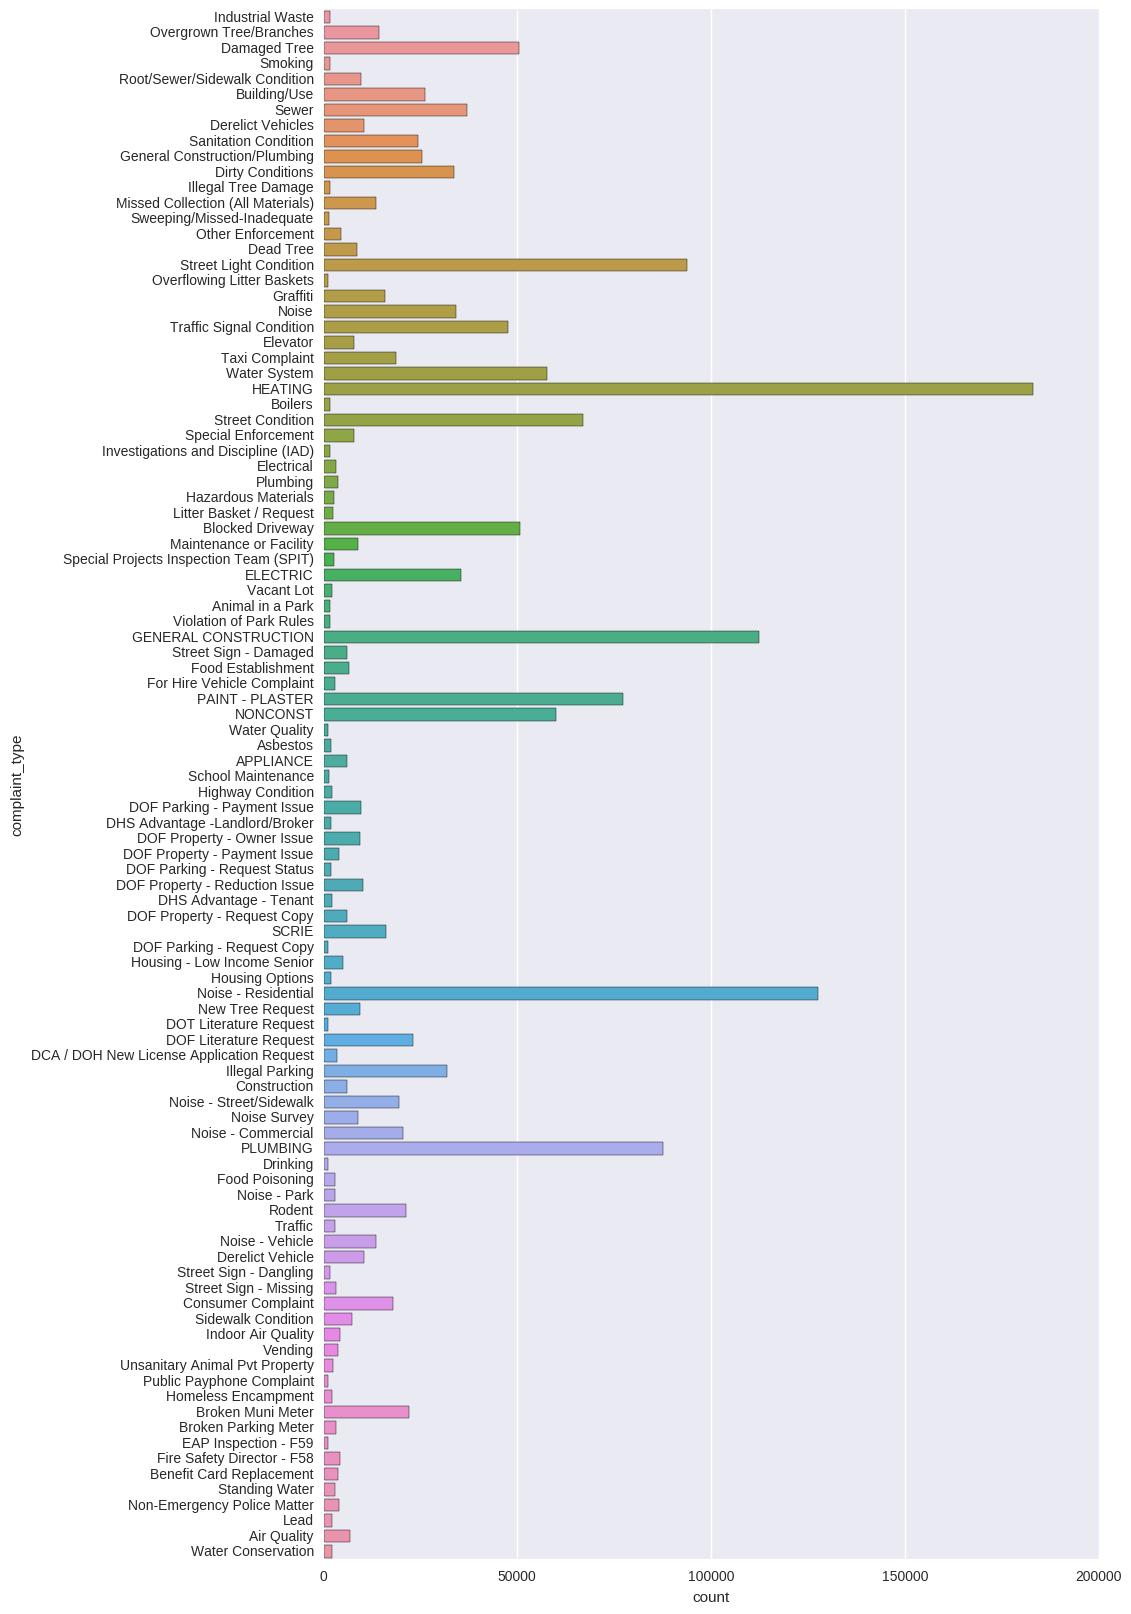

In [17]:
complaints = zips.selectExpr('complaint_type').toPandas()
complaint_counts = zips.groupBy('complaint_type').count().sort(desc('count')).toPandas()
top_complaints = complaint_counts.iloc[:100]
fig,ax = plt.subplots(1, 1, figsize=(10,20))
sns.countplot(y='complaint_type', data=complaints[complaints['complaint_type'].isin(top_complaints['complaint_type'])], ax=ax)

In [18]:
from pyspark.sql.window import Window

#zips.groupBy('zipcode', 'complaint_type').count().sort('zipcode').show(30, False)

zipWindow = Window.partitionBy('zipcode').orderBy(desc('count'))

complaintsByZip = zips.groupBy('zipcode', 'complaint_type').count().select('zipcode', F.first('complaint_type').over(zipWindow).alias('Biggest Complaint'))

complaintsByZip.groupBy('zipcode').agg(F.first('Biggest Complaint').alias('Biggest Complaint')).show(30, False)

+-------+--------------------+
|zipcode|Biggest Complaint   |
+-------+--------------------+
|14450  |Consumer Complaint  |
|29601  |Consumer Complaint  |
|10462  |HEATING             |
|10703  |Found Property      |
|11710  |Consumer Complaint  |
|10708  |Taxi Complaint      |
|33607  |Consumer Complaint  |
|10468  |HEATING             |
|77057  |Consumer Complaint  |
|10032  |HEATING             |
|11520  |Consumer Complaint  |
|33484  |SCRIE               |
|60656  |Consumer Complaint  |
|7109   |Consumer Complaint  |
|10013  |Broken Muni Meter   |
|10128  |HEATING             |
|11550  |Consumer Complaint  |
|85038  |Consumer Complaint  |
|10532  |Consumer Complaint  |
|11024  |Taxi Complaint      |
|74134  |Consumer Complaint  |
|10022  |Taxi Complaint      |
|10303  |GENERAL CONSTRUCTION|
|48195  |Consumer Complaint  |
|850067 |Consumer Complaint  |
|7726   |SCRIE               |
|7202   |Taxi Complaint      |
|7481   |Taxi Complaint      |
|10162  |SCRIE               |
|75024  

In [19]:
complaintWindow = Window.partitionBy('complaint_type').orderBy(desc('count'))

zipsByComplaint = zips.groupBy('complaint_type', 'zipcode').count().select('complaint_type', F.first('zipcode').over(zipWindow).alias('Frequentest Zip'))

zipsByComplaint.groupBy('complaint_type').agg(F.first('Frequentest Zip').alias('Frequentest Zip')).show(30, False)

+------------------------------+---------------+
|complaint_type                |Frequentest Zip|
+------------------------------+---------------+
|Traffic Signal Condition      |10462          |
|Cranes and Derricks           |10462          |
|ELECTRIC                      |10462          |
|Noise - Helicopter            |10462          |
|Broken Parking Meter          |10462          |
|Fire Alarm - New System       |10468          |
|Window Guard                  |10468          |
|Broken Muni Meter             |10462          |
|Highway Condition             |10462          |
|Street Condition              |10462          |
|Hazardous Materials           |10462          |
|DOF Literature Request        |null           |
|Vending                       |10462          |
|Ferry Permit                  |null           |
|PAINT - PLASTER               |10462          |
|Drinking Water                |10468          |
|DFTA Literature Request       |null           |
|DEP Literature Requ

In [20]:
# TODO: Normalize the above my total number of complaints in that zip.


In [21]:
monthly_complaints = zips.withColumn('month', F.month('created_date'))
monthly_complaints = monthly_complaints.filter(monthly_complaints.month.isNotNull())

In [22]:
month_window = Window.partitionBy('month').orderBy(desc('count'))

complaints_by_month = monthly_complaints.groupBy('month', 'complaint_type').count()\
                                .select('month', F.first('complaint_type').over(month_window).alias('Most Common Complaint'))
    
complaints_by_month.groupBy('month').agg(F.first('Most Common Complaint').alias('Most Common Complaint')).sort('month').show(12, False)

+-----+---------------------+
|month|Most Common Complaint|
+-----+---------------------+
|1    |HEATING              |
|2    |HEATING              |
|3    |HEATING              |
|4    |HEATING              |
|5    |Noise - Residential  |
|6    |Noise - Residential  |
|7    |Water System         |
|8    |Noise - Residential  |
|9    |Noise - Residential  |
|10   |Damaged Tree         |
|11   |HEATING              |
|12   |HEATING              |
+-----+---------------------+



In [23]:
monthlydf = monthly_complaints.groupBy('complaint_type', 'month').count().toPandas()
months = ['Jan', 'Feb', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

monthlydf['month'] = monthlydf['month'].map(lambda i:  months[i-1])

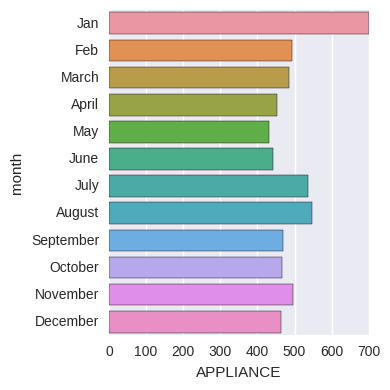

In [24]:
#fig,ax = plt.subplots(1, 1, figsize=(10,20))
#sns.countplot(y='complaint_type', hue='month', data=monthlydf)

wide = monthlydf.pivot(index='month', columns='complaint_type', values='count').sort_index(axis=1)
#wide.columns = months
wide.reset_index(inplace=True)
wide.head()
sns.factorplot(y='month', x='APPLIANCE', data=wide.sort_values(by='month'), kind='bar', order=months)

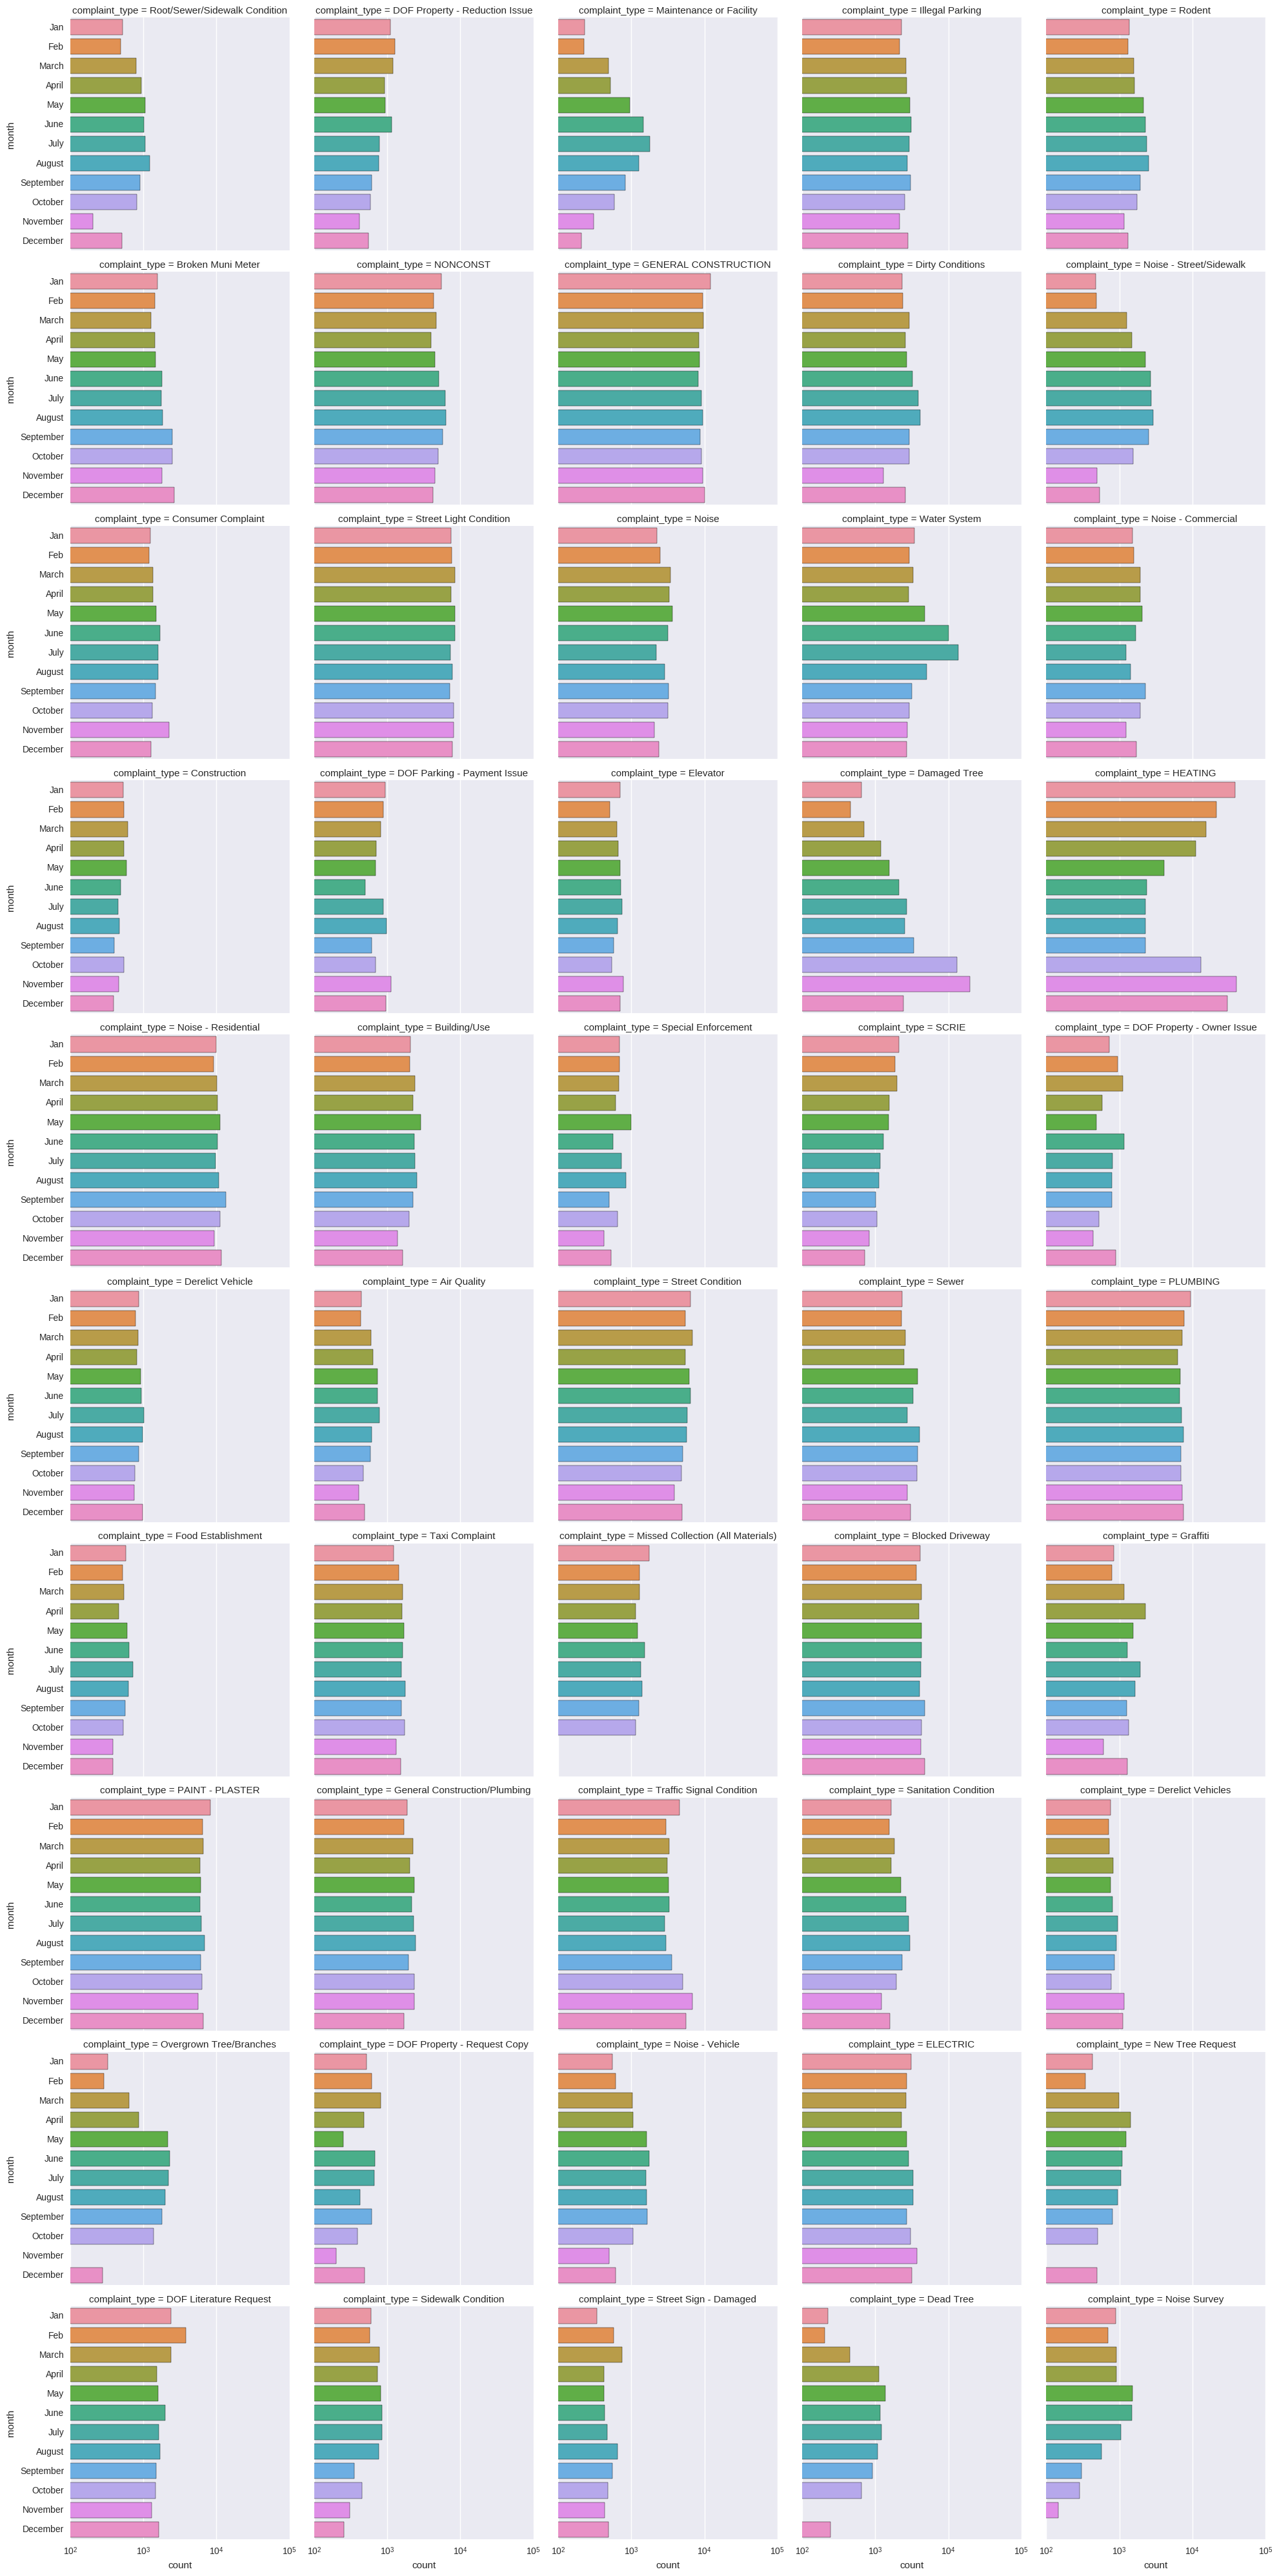

In [25]:
biggest_complaints = monthlydf.groupby('complaint_type').sum()
biggest_complaints = biggest_complaints.sort_values('count', ascending=False).iloc[:50]
biggest_complaints.head()
#biggest_complaints.shape
biggest_monthly = monthlydf.loc[monthlydf['complaint_type'].isin(biggest_complaints.index)]
biggest_monthly.head()
g = sns.factorplot(y='month', x='count', col='complaint_type', data=biggest_monthly, col_wrap=5, kind='bar', order=months)
g.set(xscale='log')

This graph is similar to the above, but instead of graphing most common complaints, tries to graph the ones that vary most overall (highest stdev).

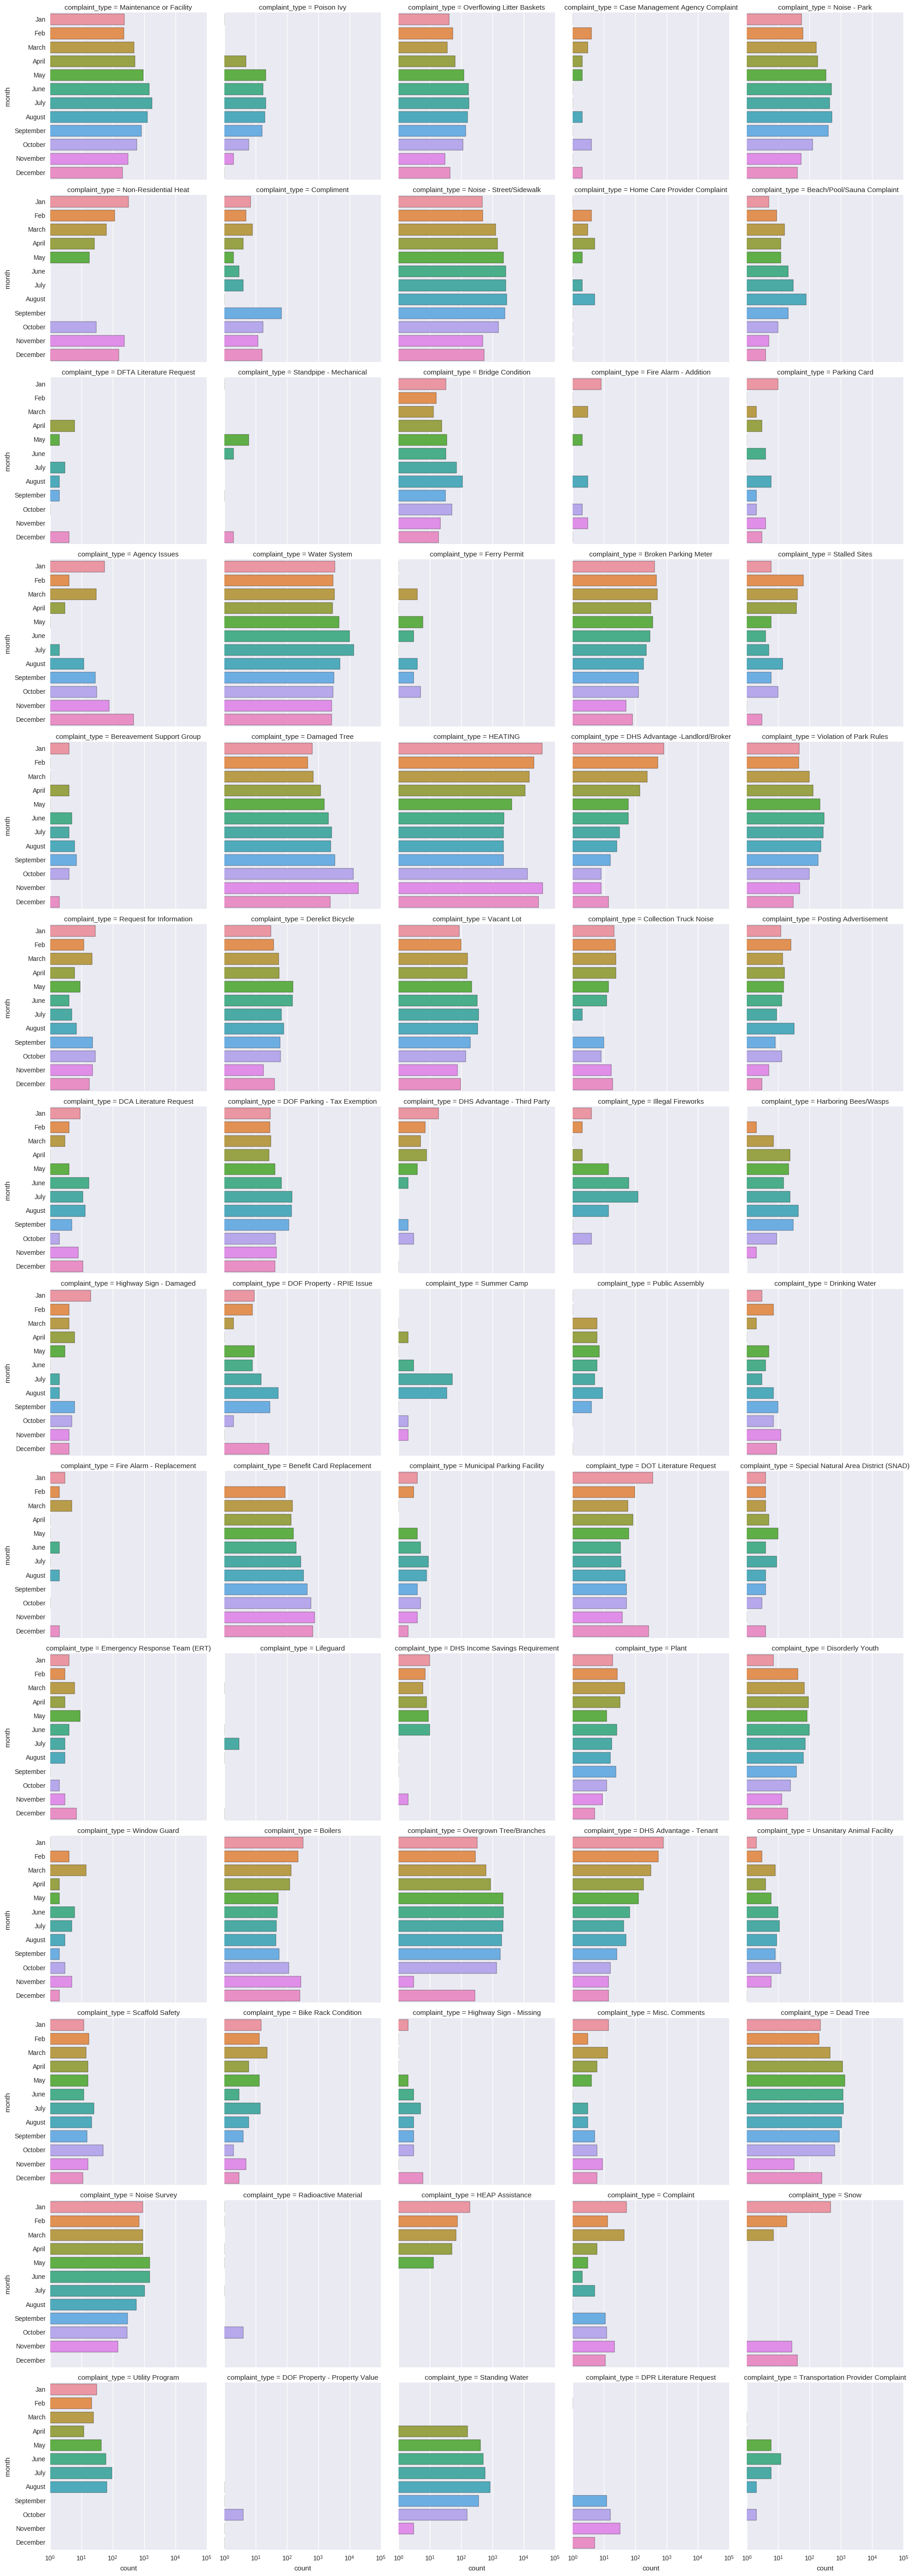

In [26]:
seasonal_complaints = monthlydf.groupby('complaint_type').aggregate(lambda x: (np.std(x) / np.mean(x))).sort_values(by='count', ascending=False).reset_index()
threshold = 0.5
biggest_sc_names = seasonal_complaints.loc[seasonal_complaints['count'] > threshold]['complaint_type']
changing_monthly = monthlydf.loc[monthlydf['complaint_type'].isin(biggest_sc_names)]
g = sns.factorplot(y='month', x='count', col='complaint_type', data=changing_monthly, col_wrap=5, kind='bar', order=months)
g.set(xscale='log')



In [71]:
#merged = zips.select("zipcode", F.concat(F.col("complaint_type"), F.lit(":"), F.col("descriptor")))
merged = zips.filter(F.col("zipcode").isNotNull() & F.col("complaint_type").isNotNull() & F.col("descriptor").isNotNull()).selectExpr("zipcode", "CONCAT(TRIM(complaint_type), ':', TRIM(descriptor)) AS full_complaint")
merged.cache()

DataFrame[zipcode: int, full_complaint: string]

In [60]:
def get_features(sparkdf, complaint_column):
    return sparkdf.groupby('zipcode').pivot(complaint_column).count().filter(F.col('zipcode').isNotNull())

In [30]:
features = get_features(zips, 'complaint_type').toPandas()

In [31]:
features.fillna(0)

,zipcode,APPLIANCE,Adopt-A-Basket,Agency Issues,Air Quality,Alzheimer's Care,Animal Facility - No Permit,Animal in a Park,Asbestos,BEST/Site Safety,...,Utility Program,Vacant Lot,Vending,Violation of Park Rules,Water Conservation,Water Quality,Water System,Weatherization,Window Guard,X-Ray Machine/Equipment
0,14450,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,29601,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10462,82.0,0.0,0.0,51.0,3.0,0.0,24.0,13.0,0.0,...,3.0,10.0,17.0,21.0,13.0,11.0,345.0,0.0,0.0,0.0
3,10703,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11710,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,33607,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,10708,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,10468,102.0,0.0,0.0,35.0,2.0,5.0,12.0,21.0,0.0,...,2.0,8.0,50.0,10.0,6.0,9.0,971.0,2.0,1.0,0.0
8,77057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,10032,101.0,1.0,0.0,40.0,2.0,0.0,13.0,16.0,3.0,...,5.0,5.0,31.0,24.0,8.0,11.0,478.0,0.0,0.0,0.0


In [72]:
merged_features = get_features(merged, "full_complaint").fillna(0)

In [75]:
merged_features.write.csv("test_write.csv", header=True)